# A Multi Target Random Forest Regression (MTRT)

In this section we develop a multi target random forest regression for the prediction of a minimum and maximum price of laptop models.


## 1. Import Statements


In [1]:
import pandas as pd
import numpy as np
import math
import io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydotplus

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import plot_tree
from sklearn.externals.six import StringIO
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from collections import defaultdict

from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import seaborn as sns

## Edit Print options
desired_width = 500
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 600)

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## 2. Dealing with missing values



In [2]:
## Importing the preprocessed data
missing_values = ["n/a", "na", "--","NAN"," ","nan","NaN",""]
data = pd.read_csv('datafile2.csv',na_values = missing_values)
data2 = pd.read_csv('datafile2_test.csv',na_values = missing_values)

## Removing missing values
# data.dropna()

## Just a temporary dataset to test the capabilities of the model
temp_data = data[['id','brand','base_name','os_details','gpu_brand','cpu_brand','cpu_type_name','gpu_type','screen_surface','screen_size','pixels_x',
                  'touchscreen','discrete_gpu','gpu','ram','ssd','detachable_keyboard','weight','storage',
                  'cpu_benchmark','gpu_benchmark','cpu_GHZ','cpu_core','threading','pc_name','min_price','max_price']]

test_data = data2[['id','brand','base_name','os_details','gpu_brand','cpu_brand','cpu_type_name','gpu_type','screen_surface','screen_size','pixels_x',
                   'touchscreen','discrete_gpu','gpu','ram','ssd', 'detachable_keyboard','weight','storage',
                   'cpu_benchmark','gpu_benchmark','cpu_GHZ','cpu_core','threading','pc_name']]

concat_df = pd.concat([temp_data , test_data])
concat_df.to_csv("/Users/Simon/Documents/GitHub/adana123/concat_df1.csv",header=True,index=True)

##### TRAINING DATA #####
## Filling in missing values: CATEGORICAL & BINARY VARIABLES
detach_key = int(temp_data.loc[:,'detachable_keyboard'].mode())
temp_data.loc[:,'detachable_keyboard'] = temp_data.loc[:,'detachable_keyboard'].fillna(0)

temp_data.loc[:,'gpu_brand'] = temp_data.loc[:,'gpu_brand'].fillna("Unknown", inplace = False) 
temp_data['cpu_type_name'] = temp_data.apply(lambda row: row['cpu_brand'] if pd.isnull(row['cpu_type_name']) 
                                             else row['cpu_type_name'], axis=1)
temp_data['gpu_type'] = temp_data['gpu_type'].fillna("No GPU", inplace = False) 
temp_data.loc[:,'screen_surface'] = temp_data.loc[:,'screen_surface'].fillna("Unknown", inplace = False) 
temp_data['os_details'] = temp_data['os_details'].fillna("Unknown", inplace = False) 
temp_data['cpu_core'] = temp_data['cpu_core'].fillna(temp_data['cpu_core'].mode())

# ## Filling in missing values: NUMERICAL VARIABLES
temp_data['weight'] = temp_data['weight'].fillna(temp_data['weight'].mean())
temp_data['cpu_benchmark'] = temp_data['cpu_benchmark'].fillna(temp_data['cpu_benchmark'].mean()) 
temp_data['gpu_benchmark'] = temp_data['gpu_benchmark'].fillna(temp_data['gpu_benchmark'].mean())
temp_data['cpu_GHZ'] = temp_data['cpu_GHZ'].fillna(temp_data['cpu_GHZ'].mean())
pixel_mode = int(temp_data.loc[:,'pixels_x'].mode())
temp_data['pixels_x'] = temp_data['pixels_x'].fillna(pixel_mode) #Modus! Most frequent number! (median)

## Showing the data
# data.head()

########################################################################################################

##### TRAINING & TESTING DATA #####
## Filling in missing values: CATEGORICAL & BINARY VARIABLES
detach_key = int(temp_data.loc[:,'detachable_keyboard'].mode())
concat_df.loc[:,'detachable_keyboard'] = concat_df.loc[:,'detachable_keyboard'].fillna(detach_key)
# print(concat_df['detachable_keyboard'])
concat_df['gpu_brand'] = concat_df['gpu_brand'].fillna("Unknown", inplace = False) 
concat_df['cpu_type_name'] = concat_df.apply(lambda row: row['cpu_brand'] if pd.isnull(row['cpu_type_name']) 
                                             else row['cpu_type_name'], axis=1)

concat_df['gpu_type'] = concat_df['gpu_type'].fillna("No GPU", inplace = False)
concat_df['gpu'] = concat_df['gpu'].fillna("No GPU", inplace = False) 
concat_df['screen_surface'] = concat_df['screen_surface'].fillna("Unknown", inplace = False) 
concat_df['os_details'] = concat_df['os_details'].fillna("Unknown", inplace = False) 
concat_df['cpu_core'] = concat_df['cpu_core'].fillna(temp_data['cpu_core'].mode())

## Filling in missing values: NUMERICAL VARIABLES
concat_df['weight'] = concat_df['weight'].fillna(temp_data['weight'].mean())
concat_df['cpu_benchmark'] = concat_df['cpu_benchmark'].fillna(temp_data['cpu_benchmark'].mean()) 
concat_df['gpu_benchmark'] = concat_df['gpu_benchmark'].fillna(temp_data['gpu_benchmark'].mean())
concat_df['cpu_GHZ'] = concat_df['cpu_GHZ'].fillna(temp_data['cpu_GHZ'].mean())

pixel_mode = int(temp_data.loc[:,'pixels_x'].mode())
concat_df.loc[:,'pixels_x'] = concat_df.loc[:,'pixels_x'].fillna(pixel_mode)



temp_data.to_csv("/Users/Simon/Documents/GitHub/adana123/temp_data.csv",header=True,index=True)
concat_df.to_csv("/Users/Simon/Documents/GitHub/adana123/concat_df2.csv",header=True,index=True)


#### Mean only from training set!

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

## 3. Feature Importance (Selection)

## 4. Splitting Data & Fitting Data

In [3]:
#### Training Data ####
## Seperating categorical - binary - numerical variables
X_cat = temp_data[['cpu_core','brand','cpu_brand','gpu','gpu_brand','cpu_type_name','screen_surface']]#,'gpu_type','os_details','base_name'
X_bin = temp_data[['touchscreen','discrete_gpu','detachable_keyboard','threading']]
X_num = temp_data[['id','screen_size','ram','ssd','storage','weight','cpu_GHZ','pixels_x','cpu_benchmark','gpu_benchmark']]#,'id']]

## Creating dummy variables:
X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)

## Merging input data
Xa = pd.concat([X_cat_dummies,X_bin,X_num], axis=1)
Xb = pd.concat([X_cat,X_bin,X_num], axis=1)
# X = pd.concat([X_cat_dummies,X_num], axis=1)
# X = X_cat_dummies

## Defining output data
Ya = temp_data[['min_price','max_price']]
Yb = Ya
# Yb = temp_data[['min_price','diff_price']]

########################################################################################
## Seperating categorical - binary - numerical variables
X_cat_test = concat_df[['cpu_core','brand','cpu_brand','gpu_brand','gpu','cpu_type_name','screen_surface']]#'pc_name','gpu_type','os_details','base_name'
X_bin_test = concat_df[['touchscreen','discrete_gpu','detachable_keyboard','threading']]
X_num_test = concat_df[['screen_size','ram','ssd','storage','weight','cpu_GHZ','pixels_x','cpu_benchmark','gpu_benchmark']]

## Creating dummy variables:
X_cat_dummies_test = pd.get_dummies(X_cat_test, drop_first=True)

## Merging input data
X_full = pd.concat([X_cat_dummies_test,X_bin_test,X_num_test], axis=1)
X_train = X_full.head(len(data))
X_test = X_full.tail(len(data2))

########################################################################################
## Splitting the dataset into train and test sets
# Predict Minimum and Maximum prices
X_train_a, X_test_a, Y_train_a, Y_test_a = train_test_split(Xa, Ya, test_size=0.3, random_state=42)


#Split without creating dummies for easy analysis
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(Xb, Yb, test_size=0.3, random_state=42)

trainingdata = pd.concat([X_train_b, Y_train_b], axis=1, sort=False)
testingdata = pd.concat([X_test_b, Y_test_b], axis=1, sort=False)

trainingdata.to_csv("/Users/Simon/Documents/GitHub/adana123/trainingdata.csv",header=True,index=True)
testingdata.to_csv("/Users/Simon/Documents/GitHub/adana123/testingdata.csv",header=True,index=True)


## 2 models
del X_train_a['id'] #need to delete a useless feature first
del X_test_a['id']

Model1 = RandomForestRegressor(n_estimators = 400,criterion='mae',random_state = 42)
Model1.fit(X_train_a,Y_train_a)

# Model2 = RandomForestRegressor(n_estimators = 200,criterion='mae',random_state = 0)
# Model2.fit(X_train_b,Y_train_b)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## 5. Measuring Mean Summed Absolute Error

### A: MSAE for predicting minimum and maximum  price

In [4]:
## Predicting the target values
Y_pred = Model1.predict(X_test_a)

## Calculating the score
MAE = mean_absolute_error(Y_test_a, Y_pred, multioutput='raw_values')
print(MAE[0]+MAE[1])

## Turn DF to array
Y_test_array = Y_test_a.to_numpy()

Sum_error = 0
Test_Results = []

for i in range(len(Y_pred)):
    
    temp_test_results = []
    
#     Y_id = X_test_b['id'][i]
    Y_pred_min = Y_pred[i][0]
    Y_pred_max = Y_pred[i][1]
    Y_test_min = Y_test_array[i][0]
    Y_test_max = Y_test_array[i][1]
    
    temp_test_results = [Y_pred_min,Y_test_min,Y_pred_max,Y_test_max]
    Test_Results.append(temp_test_results)
    
    Error_min = abs(Y_pred_min - Y_test_min)
    Error_max = abs(Y_pred_max - Y_test_max)
    Total_error = Error_min + Error_max
    
    Sum_error = Sum_error + Total_error
    counter = i

Avg_error = Sum_error / counter
MSAE = Avg_error
print(MSAE)



334.19289616013054
336.39153363486844


In [5]:
# Array --> Datafame
Test_Results = pd.DataFrame(Test_Results,columns=['pred_min_price','act_min_price','pred_max_price','act_max_price'])

# Reset Indexes of DF
X_test_b.reset_index(inplace=True) 
Test_Results.reset_index(inplace=True,drop=True) 

# Copy the ID column
Test_Results.loc[:,'id'] = X_test_b.loc[:,'id']

# Set ID as new Index
X_test_b.set_index('id')
Test_Results.set_index('id')

# Merge the features with the results
testingdata_results = X_test_b.merge(Test_Results, left_index=True, right_index=True)
# testingdata_results = pd.concat([X_test_b, Test_Results], axis=1, sort=False)
# testingdata_results.drop(['id_x'],axis=1)
# testingdata_results.drop(['id_y'],axis=1)
testingdata_results.to_csv("/Users/Simon/Documents/GitHub/adana123/testingdata_results.csv",header=True,index=True)
testingdata_results.head(len(testingdata_results))

,index,cpu_core,brand,cpu_brand,gpu,gpu_brand,cpu_type_name,screen_surface,touchscreen,discrete_gpu,detachable_keyboard,threading,id_x,screen_size,ram,ssd,storage,weight,cpu_GHZ,pixels_x,cpu_benchmark,gpu_benchmark,pred_min_price,act_min_price,pred_max_price,act_max_price,id_y
0,480,QUAD-CORE,DELL,AMD,AMD RADEON VEGA 10,AMD,RYZEN 7,GLOSSY,1,0,0.0,1.0,23196,13.3,12,256,256,3.860000,2.200000,1920,6903.000000,1571.000000,598.818800,512.99,608.694150,517.99,23196
1,449,HEXA-CORE,MSI,INTEL,NVIDIA GEFORCE GTX 1060,NVIDIA,CORE I7,MATTE,0,1,0.0,1.0,26773,15.6,16,512,512,4.140000,2.200000,1920,10418.000000,10210.000000,1666.945300,2099.00,1763.655075,2099.00,26773
2,475,QUAD-CORE,HP,INTEL,INTEL UHD 620,INTEL,CORE I5,GLOSSY,1,0,0.0,1.0,27887,15.6,12,0,1000,4.230000,1.600000,1366,6372.000000,888.000000,584.135975,621.00,594.392287,621.99,27887
3,434,DUAL-CORE,APPLE,INTEL,INTEL HD 6000,INTEL,CORE I5,GLOSSY,0,0,0.0,1.0,28480,11.6,4,128,128,2.380000,1.600000,1366,2142.000000,829.000000,387.087638,418.00,417.410575,418.00,28480
4,368,QUAD-CORE,ACER,INTEL,INTEL HD,INTEL,ATOM,MATTE,0,0,0.0,0.0,29847,15.6,4,16,16,4.300000,1.040000,1366,1196.000000,10.000000,217.037000,197.97,224.705475,197.99,29847
5,55,DUAL-CORE,ACER,INTEL,NVIDIA GEFORCE 940M,NVIDIA,CORE I5,MATTE,0,1,0.0,1.0,7495,15.6,8,0,1000,5.290000,2.200000,1920,2546.000000,1048.000000,724.791450,789.00,746.941925,789.00,7495
6,322,QUAD-CORE,ACER,INTEL,NVIDIA GEFORCE GTX 1050 TI,NVIDIA,CORE I5,MATTE,0,1,0.0,0.0,23606,15.6,8,256,256,5.950000,2.500000,1920,5260.000000,6657.000000,782.600275,705.98,797.201900,748.00,23606
7,76,HEXA-CORE,ALIENWARE,INTEL,NVIDIA GEFORCE GTX 1060,NVIDIA,CORE I7,MATTE,0,1,0.0,1.0,26135,17.3,8,256,1256,9.740000,2.200000,1920,10418.000000,10210.000000,1105.363000,1699.00,1129.173850,1699.00,26135
8,504,DUAL-CORE,LENOVO,INTEL,INTEL HD 500,INTEL,CELERON,MATTE,0,0,0.0,0.0,20733,15.6,4,0,1000,4.850000,1.100000,1366,1123.000000,317.000000,306.979225,299.99,316.067850,342.00,20733
9,347,QUAD-CORE,ASUS,INTEL,NVIDIA GEFORCE GTX 1050,NVIDIA,CORE I7,MATTE,0,1,0.0,1.0,17467,15.6,16,256,1256,5.100000,2.800000,1920,7069.000000,5595.000000,1275.179562,938.00,1356.881575,938.00,17467


### B: MSAE for predicting minimum price and price difference

**Result:** No significant improvement was obtained. This is as expected because the regression tree considers the two outputs, min and max price, at the same time. They are not considered independent and the splits are based on improving both outputs.

In [6]:
# Y_pred = Model2.predict(X_test_b)

# ## Turn DF to array
# Y_test_array = Y_test_b.to_numpy()

# Sum_error = 0
# Y_pred_min_array = []
# for i in range(len(Y_pred)):
# #     print(Y_pred[i],Y_test_array[i])
#     Y_pred_min = Y_pred[i][0]
#     Y_pred_max = Y_pred_min + Y_pred[i][1]
#     Y_test_min = Y_test_array[i][0]
#     Y_test_max = Y_test_min + Y_test_array[i][1]
    
#     Y_pred_min_array.append(Y_pred_min)
    
#     Error_min = abs(Y_pred_min - Y_test_min)
#     Error_max = abs(Y_pred_max - Y_test_max)
#     Total_error = Error_min + Error_max
    
#     Sum_error = Sum_error + Total_error
#     counter = i

# Avg_error = Sum_error / counter
# MSAE = Avg_error
# print('The MSAE = ', round(MSAE,3))



## 6. Validation of Model

### 6.1 Random Forest Tuning 

The code and graph below show that the Random Forest Regressor does not suffer from model overfitting in terms of hyperparameters. By increasing the number of estimators, the model simply converges to a constant mean summed absolute error. It is also important to note that the deviation from the convergence value of the MSAE decreases as the number of trees increase. The model becomes less irradic and more robust in its predictions as the number of trees increases. This is logical since for a single prediction of the price an average is taken with a length of the number of trees. This makes tuning very easy. The model just requires enough trees. It is not possible to overfit the model by increasing the number of trees. 

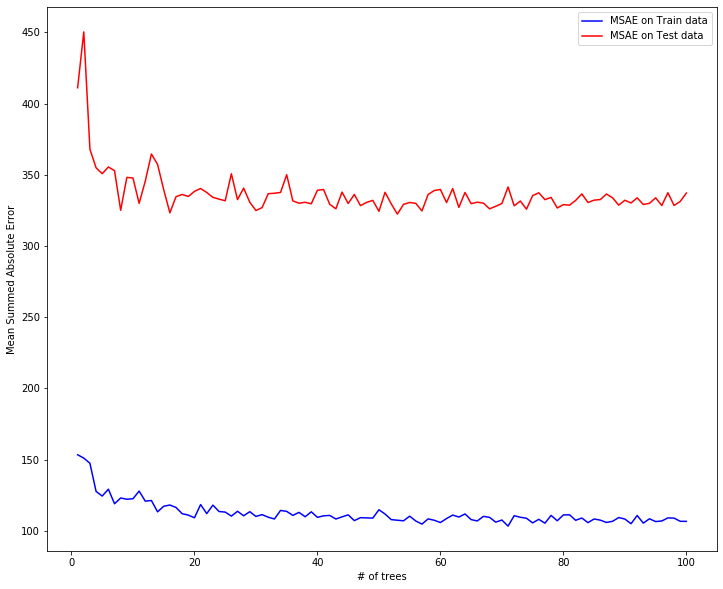

In [7]:
def estimator_tuning(max_trees,X_train_a, Y_train_a, X_test_a, Y_test_a):

    RF1 = RandomForestRegressor(n_estimators=1) #,criterion='mae',random_state = 42)
    trees, train_loss, test_loss = [], [], []
    
    for iter in range(max_trees):
        RF1.fit(X_train_a,Y_train_a)
        Y_train_predicted = RF1.predict(X_train_a)
        Y_test_predicted = RF1.predict(X_test_a)

        MAE_train = mean_absolute_error(Y_train_a, Y_train_predicted, multioutput='raw_values')
        MAE_test = mean_absolute_error(Y_test_a, Y_test_predicted, multioutput='raw_values')
        MSAE_train = MAE_train[0]+MAE_train[1]
        MSAE_test = MAE_test[0]+MAE_test[1]

#         print("Iteration: {} Train msae: {} Test msae: {}".format(iter, MSAE_train, MSAE_test))

        trees += [RF1.n_estimators]
        train_loss += [MSAE_train]
        test_loss += [MSAE_test]
        RF1.n_estimators += 1   
        
    return trees, train_loss, test_loss

trees, train_loss, test_loss = estimator_tuning(100,X_train_a, Y_train_a, X_test_a, Y_test_a)

plt.figure(figsize=(12,10))  
plt.plot(trees, train_loss, color="blue", label="MSAE on Train data")
plt.plot(trees, test_loss, color="red", label="MSAE on Test data")
plt.xlabel("# of trees")
plt.ylabel("Mean Summed Absolute Error");
plt.legend()


### 6.2 Input Feature Tuning

It is also important to note the effect of specific standard and engineered features on the models accuracy. In this section the effect of a feature in the model is quantified. We quantify the effect of a feature via the adjusted coefficient of determination (adjusted $r^2$). First, the function for this metric is defined. Next, through cross-validation and shuffling of the features a mean adjusted $r^2$ score is calculated for every feature. By splitting the data randomly a number of times, it is possible to fairly accuratly approach the true $r^2$ values. There is however a catch: the features might still be correlated with eachother. In the data exploration, obvious correlations between features have already been determined and only one of the correlated features was included. 

An obvious example is x_pixels vs y_pixels. Whenever the number of pixels in the x-direction changes, usually so does the number of pixels in the y-direction and therefore it suffices the only include one of the two features. If the other feature were included than this would show a very low adjusted $r^2$ value. 

In [8]:
## A function for calculating the adjusted coefficient of determination
def adj_r2_score(clf, X, y):
    """Calculate the adjusted :math:`R^2` of the model.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].

    Returns
    -------
    float
        The adjusted :math:`R^2` of the model.
    """
    n = X.shape[0]  # Number of observations
    p = X.shape[1]  # Number of features
    r_squared = r2_score(y, clf.predict(X))
    acc = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1)) 
    return acc

In [9]:
X_cat = temp_data[['cpu_core','brand','cpu_brand','gpu_brand','cpu_type_name','screen_surface']]#,'gpu','gpu_type','os_details','base_name'
X_bin = temp_data[['touchscreen','discrete_gpu','detachable_keyboard','threading']]
X_num = temp_data[['screen_size','ram','ssd','storage','weight','cpu_GHZ','pixels_x','cpu_benchmark','gpu_benchmark']]#,'id']]

## Creating dummy variables:
X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)

## Merging input data
Xa = pd.concat([X_cat_dummies,X_bin,X_num], axis=1)

def feature_ranking(names_x,Xa,Ya):
    #crossvalidate the scores on a number of different random splits of the data
    RF2 = RandomForestRegressor(n_estimators = 100,criterion='mae')#,random_state = 42)
    scores = defaultdict(list)


    for a in range(50):
#         RF2 = RandomForestRegressor(n_estimators = 300)#,random_state = 42)
        X_train_a, X_test_a, Y_train_a, Y_test_a = train_test_split(Xa, Ya, test_size=0.3)
        r = RF2.fit(X_train_a, Y_train_a)
#         acc = r2_score(Y_test_a, RF2.predict(X_test_a)) 
        acc = adj_r2_score(RF2,X_test_a,Y_test_a)
        
        for b in range(Xa.shape[1]):
            X_t = X_test_a.copy()
            np.random.shuffle(X_t[:, b])
#             shuff_acc = r2_score(Y_test_a, RF2.predict(X_t))
            shuff_acc = adj_r2_score(RF2,X_t,Y_test_a) 
            scores[names_x[b]].append((acc-shuff_acc)/acc)
            
            sorted_scores = sorted([(round(np.mean(score), 4), feat) for
                  feat, score in scores.items()], reverse=True)
            
    return sorted_scores

X_array = Xa.to_numpy()
Y_array = Ya.to_numpy()
names_x = list(Xa.columns.values)
names_y = list(Ya.columns.values)
names = names_x + names_y

sorted_scores = feature_ranking(names_x,X_array,Y_array)
print(sorted_scores)


[(0.5929, 'ram'), (0.4579, 'cpu_type_name_CORE I7'), (0.204, 'gpu_benchmark'), (0.1536, 'pixels_x'), (0.0515, 'weight'), (0.0343, 'ssd'), (0.0341, 'brand_RAZER'), (0.0334, 'cpu_benchmark'), (0.0226, 'storage'), (0.0167, 'cpu_type_name_CORE I5'), (0.0115, 'brand_APPLE'), (0.0087, 'cpu_GHZ'), (0.0082, 'gpu_brand_NVIDIA'), (0.005, 'brand_LENOVO'), (0.0041, 'screen_surface_MATTE'), (0.0037, 'touchscreen'), (0.0037, 'threading'), (0.003, 'brand_OTHER'), (0.0024, 'discrete_gpu'), (0.0022, 'cpu_type_name_CELERON'), (0.0014, 'brand_MICROSOFT'), (0.0011, 'cpu_type_name_CORE I3'), (0.0011, 'brand_ALIENWARE'), (0.001, 'detachable_keyboard'), (0.001, 'brand_HP'), (0.0008, 'cpu_core_HEXA-CORE'), (0.0004, 'screen_size'), (0.0004, 'cpu_brand_INTEL'), (0.0002, 'cpu_type_name_RYZEN 5'), (0.0001, 'gpu_brand_INTEL'), (0.0001, 'brand_LG'), (-0.0, 'screen_surface_Unknown'), (0.0, 'gpu_brand_Unknown'), (0.0, 'gpu_brand_POWERVR'), (0.0, 'gpu_brand_MALI-T860'), (0.0, 'gpu_brand_IMAGINATION'), (0.0, 'cpu_type_

In [10]:
print(sorted_scores[0][0])

0.5929


No handles with labels found to put in legend.


['ram', 'cpu_type_name_CORE I7', 'gpu_benchmark', 'pixels_x', 'weight', 'ssd', 'brand_RAZER', 'cpu_benchmark', 'storage', 'cpu_type_name_CORE I5', 'brand_APPLE', 'cpu_GHZ', 'gpu_brand_NVIDIA', 'brand_LENOVO', 'screen_surface_MATTE']
[0.5929, 0.4579, 0.204, 0.1536, 0.0515, 0.0343, 0.0341, 0.0334, 0.0226, 0.0167, 0.0115, 0.0087, 0.0082, 0.005, 0.0041]


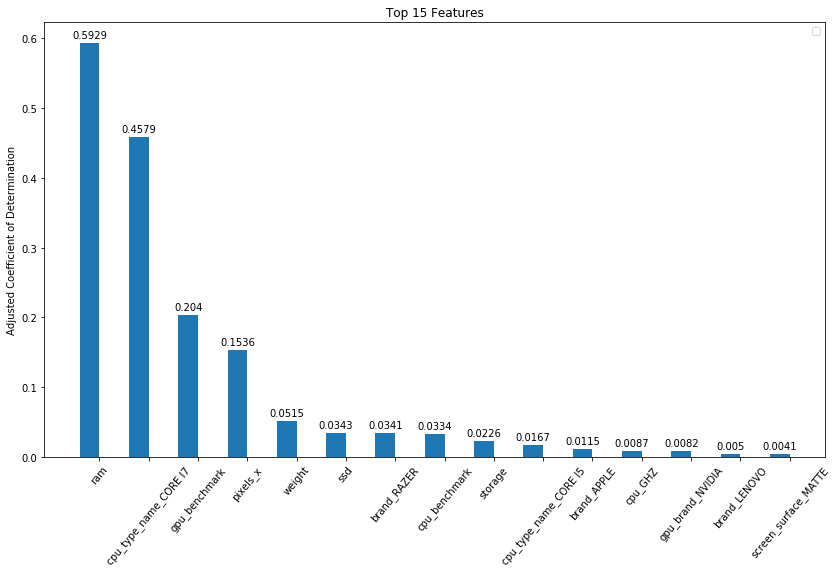

In [11]:
# Visualizing adjusted coefficient of determination
labels = []
r_score = []
top_features = 15

for a in range(top_features):
    r_score.append(sorted_scores[a][0])
    labels.append(sorted_scores[a][1])
    
print(labels)
print(r_score)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(14,8))
rects1 = ax.bar(x - width/2, r_score, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Adjusted Coefficient of Determination')
ax.set_title('Top ' + str(top_features) + ' Features')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()
plt.xticks(rotation=50)
plt.show()

## 7. Predicting the test set

In [19]:
Model_Final = RandomForestRegressor(n_estimators = 1500,criterion='mae',random_state = 1)
Model_Final.fit(X_train,Ya)
Y_pred_test = Model_Final.predict(X_test)

RESULTS = []
for i in range(len(data2)):
    temp_result = []
    temp_result.append(data2['id'][i])
    temp_result.append(Y_pred_test[i][0])
    temp_result.append(Y_pred_test[i][1])
    RESULTS.append(temp_result)

RESULTS = pd.DataFrame(RESULTS,columns=['id','pred_min_price','pred_max_price'])
print(RESULTS)



        id  pred_min_price  pred_max_price
0    28807     1134.870157     1201.351163
1    22559      387.260830      404.441187
2    28647      812.627720      837.732520
3    22141      539.488377      556.233570
4    26116     2120.133467     2277.885373
5    27111     1426.302800     1474.115647
6    23420      623.497333      649.130347
7    21464      176.708933      182.493140
8    29405      724.204870      760.924067
9    27107      407.119153      418.358347
10   26141      967.903400      999.354357
11   25928     1693.143120     1780.425607
12   24845      712.290403      772.846153
13   28804      359.293627      370.870473
14   26772      610.062610      616.740990
15   27413      921.349217      958.715263
16    7261      879.480957      924.598847
17   31424      799.589710      823.023227
18    3940      407.876900      418.563843
19   16238      533.073810      550.847843
20   29407     1291.823747     1339.334510
21   24011      387.670517      405.910307
22    8542 

In [15]:
RESULTS.to_csv("/Users/Simon/Documents/GitHub/adana123/RESULTS.csv",header=False,index=False)

## 8. Evaluation of Model Results

In [27]:
# Loading the dataframe
Private_LB = pd.read_csv('Private_LB.csv')#,na_values = missing_values)

# Merging the predictions with the 
Private_LB_Results = pd.merge(Private_LB,RESULTS,on='id')
Private_LB_Results = Private_LB_Results.rename(columns={'min_price': 'act_min_price', 'max_price': 'act_max_price'})

Private_LB_Results.head(100)

Private_LB_Results.to_csv("/Users/Simon/Documents/GitHub/adana123/Private_LB_Results.csv",header=True,index=True)

